In [2]:
import numpy as np

DATA_DIR = '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/data/'
GRAPH_PATH = '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/graph/'
MODEL_DIR = '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/model/'
SAMPLE_FRAC = 0.0000001    
SAMPLE_SIZE = 10_000
BATCH_SIZE = 1_000_000

SVM_ALPHA_RANGE = np.fromfunction(lambda i: 1e-15 * pow(10, i), (15,), dtype=float)
SVM_MAX_ITER_RANGE = np.fromfunction(lambda i: 10 * (i + 1), (20,), dtype=float)

FEATURES = [
    'DeviceClass',
    'DeviceName',
    'DeviceBrand',
    'DeviceCpu',
    'DeviceCpuBits',
    'OperatingSystemClass',
    'OperatingSystemName',
    'OperatingSystemVersion',
    'OperatingSystemNameVersion',
    'OperatingSystemVersionBuild',
    'LayoutEngineClass',
    'LayoutEngineName',
    'LayoutEngineVersion',
    'LayoutEngineVersionMajor',
    'LayoutEngineNameVersion',
    'LayoutEngineNameVersionMajor',
    'AgentClass',
    'AgentName',
    'AgentVersion',
    'AgentVersionMajor',
    'AgentNameVersion',
    'AgentNameVersionMajor',
#     'from',
#     'to',
#     'url',
#     'requestType',
    'operation'
]

In [3]:
!pip install pyarrow
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import seaborn as sns
import user_agents
%matplotlib inline
from matplotlib import pyplot as plt
pd.set_option("display.precision", 2)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.externals import joblib
from sklearn.model_selection import RandomizedSearchCV

import os

import warnings
warnings.filterwarnings('ignore')

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Подготока моделей

#### Hashing Trick - единственный нормальный подход https://habr.com/company/ods/blog/326418/

In [3]:
class HashingTrick(TransformerMixin):
    
    _default_hashing_trick_modulars = {
        'DeviceClass': 10000,
        'DeviceName': 10000,
        'DeviceBrand': 10000,
        'DeviceCpu': 10000,
        'DeviceCpuBits': 10000,
        'OperatingSystemClass': 10000,
        'OperatingSystemName': 10000,
        'OperatingSystemVersion': 10000,
        'OperatingSystemNameVersion': 10000,
        'OperatingSystemVersionBuild': 10000,
        'LayoutEngineClass': 10000,
        'LayoutEngineName': 10000,
        'LayoutEngineVersion': 10000,
        'LayoutEngineVersionMajor': 10000,
        'LayoutEngineNameVersion': 10000,
        'LayoutEngineNameVersionMajor': 10000,
        'AgentClass': 10000,
        'AgentName': 10000,
        'AgentVersion': 10000,
        'AgentVersionMajor': 10000,
        'AgentNameVersion': 10000,
        'AgentNameVersionMajor': 10000,
        'from': 10000,
        'to': 10000,
        'url': 10000000,
        'requestType': 10000,
        'operation': 10000
    }
    
    def __init__(self, hashing_trick_modulars = _default_hashing_trick_modulars):
        self.hashing_trick_modulars = hashing_trick_modulars
    
    def set_params(self, **kwargs):
        """Set the parameters of this estimator."""
    
    def get_params(self, **kwargs):
        return {"hashing_trick_modulars": self.hashing_trick_modulars}
        
    def _hashing_trick(self, x, n):
        return hash(x) % n

    def _column_hashing_trick(self, col_name):
        self.http[col_name] = self.http[col_name].apply(self._hashing_trick, args=(self.hashing_trick_modulars[col_name],))
  
    def fit_transform(self, X, *_):
        return self.transform(X)
        
    def transform(self, X, *_):
        self.http = X
        for feature in FEATURES:
            self._column_hashing_trick(feature)

        return self.http
    
    def fit(self, *_):
        return self

In [4]:
ht = HashingTrick()
ohe = OneHotEncoder(handle_unknown='ignore')
clf = SGDClassifier(random_state=17, max_iter=1000, alpha=0.0000001, loss='log')
pipeline = Pipeline(
    [('ht', ht)] +
    [('ohe', ohe)]+
    [('sgd', clf)]
)

## Поиск гиперпаратметров
#### Используется RandomizedSearchCV, так полный GridSearchCV работает долго

In [ ]:
http = pq.read_table(DATA_DIR + 'HTTPRequests-20180331-test_parsed.parquet', columns=FEATURES ).to_pandas().sample(frac=SAMPLE_FRAC)
target = pq.read_table(DATA_DIR + 'HTTPRequests-20180331-test_parsed.parquet', columns=['isBot'] ).to_pandas().sample(frac=SAMPLE_FRAC)

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(http, target, test_size=0.1, random_state=17)

In [ ]:
params = {'sgd__alpha': SVM_ALPHA_RANGE,
              'sgd__max_iter': SVM_MAX_ITER_RANGE}
search = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, verbose=True, scoring='f1', n_iter = 10)
search.fit(X_train, y_train)
print(search.best_params_, search.best_score_)
print(classification_report(y_holdout, search.predict(X_holdout), target_names = ['users', 'bots']))

## Создание моделей по полученным из search гиперпараметрам

In [ ]:
clf = SGDClassifier(random_state = 17, 
                    max_iter = search.best_params_['sgd__max_iter'], 
                    alpha = search.best_params_['sgd__alpha'],
                    loss = 'log')
ht = HashingTrick().fit(http)
ohe = OneHotEncoder(handle_unknown='ignore').fit(ht.transform(http))

## Сохранение моделей

In [ ]:
joblib.dump(ht, MODEL_DIR + 'http_ua_from_parquet_onehotencoder_hasging_trick.pkl') 
joblib.dump(ohe, MODEL_DIR + 'http_ua_from_parquet_onehotencoder_ohe.pkl')
joblib.dump(clf, MODEL_DIR + 'http_ua_from_parquet_onehotencoder_sgd.pkl')

## Обучение на большой выборке 

In [5]:
ht = joblib.load(MODEL_DIR + 'http_ua_from_parquet_onehotencoder_hasging_trick.pkl') 
ohe = joblib.load(MODEL_DIR + 'http_ua_from_parquet_onehotencoder_ohe.pkl')
clf = joblib.load(MODEL_DIR + 'http_ua_from_parquet_onehotencoder_sgd.pkl')

In [6]:
train_batches = pq.read_table(DATA_DIR + 'HTTPRequests-20180331-test_parsed.parquet', 
                        columns=FEATURES + ['isBot']).to_batches(BATCH_SIZE)

In [7]:
first = True
for batch in train_batches:
    http = batch.to_pandas()
    X = http[FEATURES]
    y = http['isBot']
    X = ht.transform(X)
    X = ohe.transform(X)
    if (first):
        clf.fit(X, y) # Проблема, когда 'y' состоит только из пользователей
        first = False
    else:
        clf.partial_fit(X, y)

In [8]:
joblib.dump(clf, MODEL_DIR + 'http_ua_from_parquet_onehotencoder_sgd_fitted.pkl')

['/home/nsuprotivniy/Documents/Работа/OKru/Antispam/model/http_ua_from_parquet_onehotencoder_sgd_fitted.pkl']

## Классификация для большой выборки

In [55]:
ht = joblib.load(MODEL_DIR + 'http_ua_from_parquet_onehotencoder_hasging_trick.pkl') 
ohe = joblib.load(MODEL_DIR + 'http_ua_from_parquet_onehotencoder_ohe.pkl')
clf = joblib.load(MODEL_DIR + 'http_ua_from_parquet_onehotencoder_sgd_fitted.pkl')

In [56]:
predict_batches  = pq.read_table(DATA_DIR + 'HTTPRequests-20180331-train_parsed.parquet', 
                        columns=FEATURES + ['isBot']).to_batches(BATCH_SIZE)

In [57]:
predict_out = 'HTTPRequests-20180331_parsedUA_predicted.parquet'
predicted_writer = pq.ParquetWriter(DATA_DIR + predict_out, 
                                    pa.Table.from_pandas(pd.DataFrame({'predict_proba': []}, dtype=np.float64)).schema)

In [58]:
for batch in predict_batches:
    http = batch.to_pandas()
    X = http[FEATURES]
    X = ht.transform(X)
    X = ohe.transform(X)
    predicted = clf.predict_proba(X)
    table = pa.Table.from_pandas(pd.DataFrame({'predict_proba': predicted[:,1]}, dtype=np.float64))
    predicted_writer.write_table(table)

In [59]:
predicted_writer.close()

## Тестирование для большой выборки

In [4]:
predicted_proba = pq.read_table(DATA_DIR + 'HTTPRequests-20180331_parsedUA_predicted.parquet',
                                columns=['predict_proba']).to_pandas()

real = pq.read_table(DATA_DIR + 'HTTPRequests-20180331-train_parsed.parquet',
                                columns=['isBot']).to_pandas()

In [23]:
bound = 0.9
predicted = (predicted_proba.values.ravel() > bound).astype(np.int32)

In [24]:
print(classification_report(real, predicted, target_names = ['users', 'bots']))

             precision    recall  f1-score   support

      users       1.00      1.00      1.00   7778516
       bots       0.47      0.00      0.01      6663

avg / total       1.00      1.00      1.00   7785179



In [25]:
predicted_proba.values.min(), predicted_proba.values.max(), predicted_proba.values.mean()

(0.0, 1.0, 6.037112752757325e-06)

In [26]:
real_userId = pq.read_table(DATA_DIR + 'HTTPRequests-20180331-train_parsed.parquet',
                                columns=['isBot', 'userId']).to_pandas()

In [27]:
real_userId['predict_proba'] = predicted_proba['predict_proba']

In [28]:
grouped = real_userId.groupby('userId').max()

In [29]:
grouped['predict'] = (grouped['predict_proba'] > bound).astype(np.int32)

In [30]:
print(classification_report(grouped['isBot'], grouped['predict'], target_names = ['users', 'bots']))

             precision    recall  f1-score   support

      users       1.00      1.00      1.00     19645
       bots       0.39      0.62      0.48        21

avg / total       1.00      1.00      1.00     19666



No handles with labels found to put in legend.


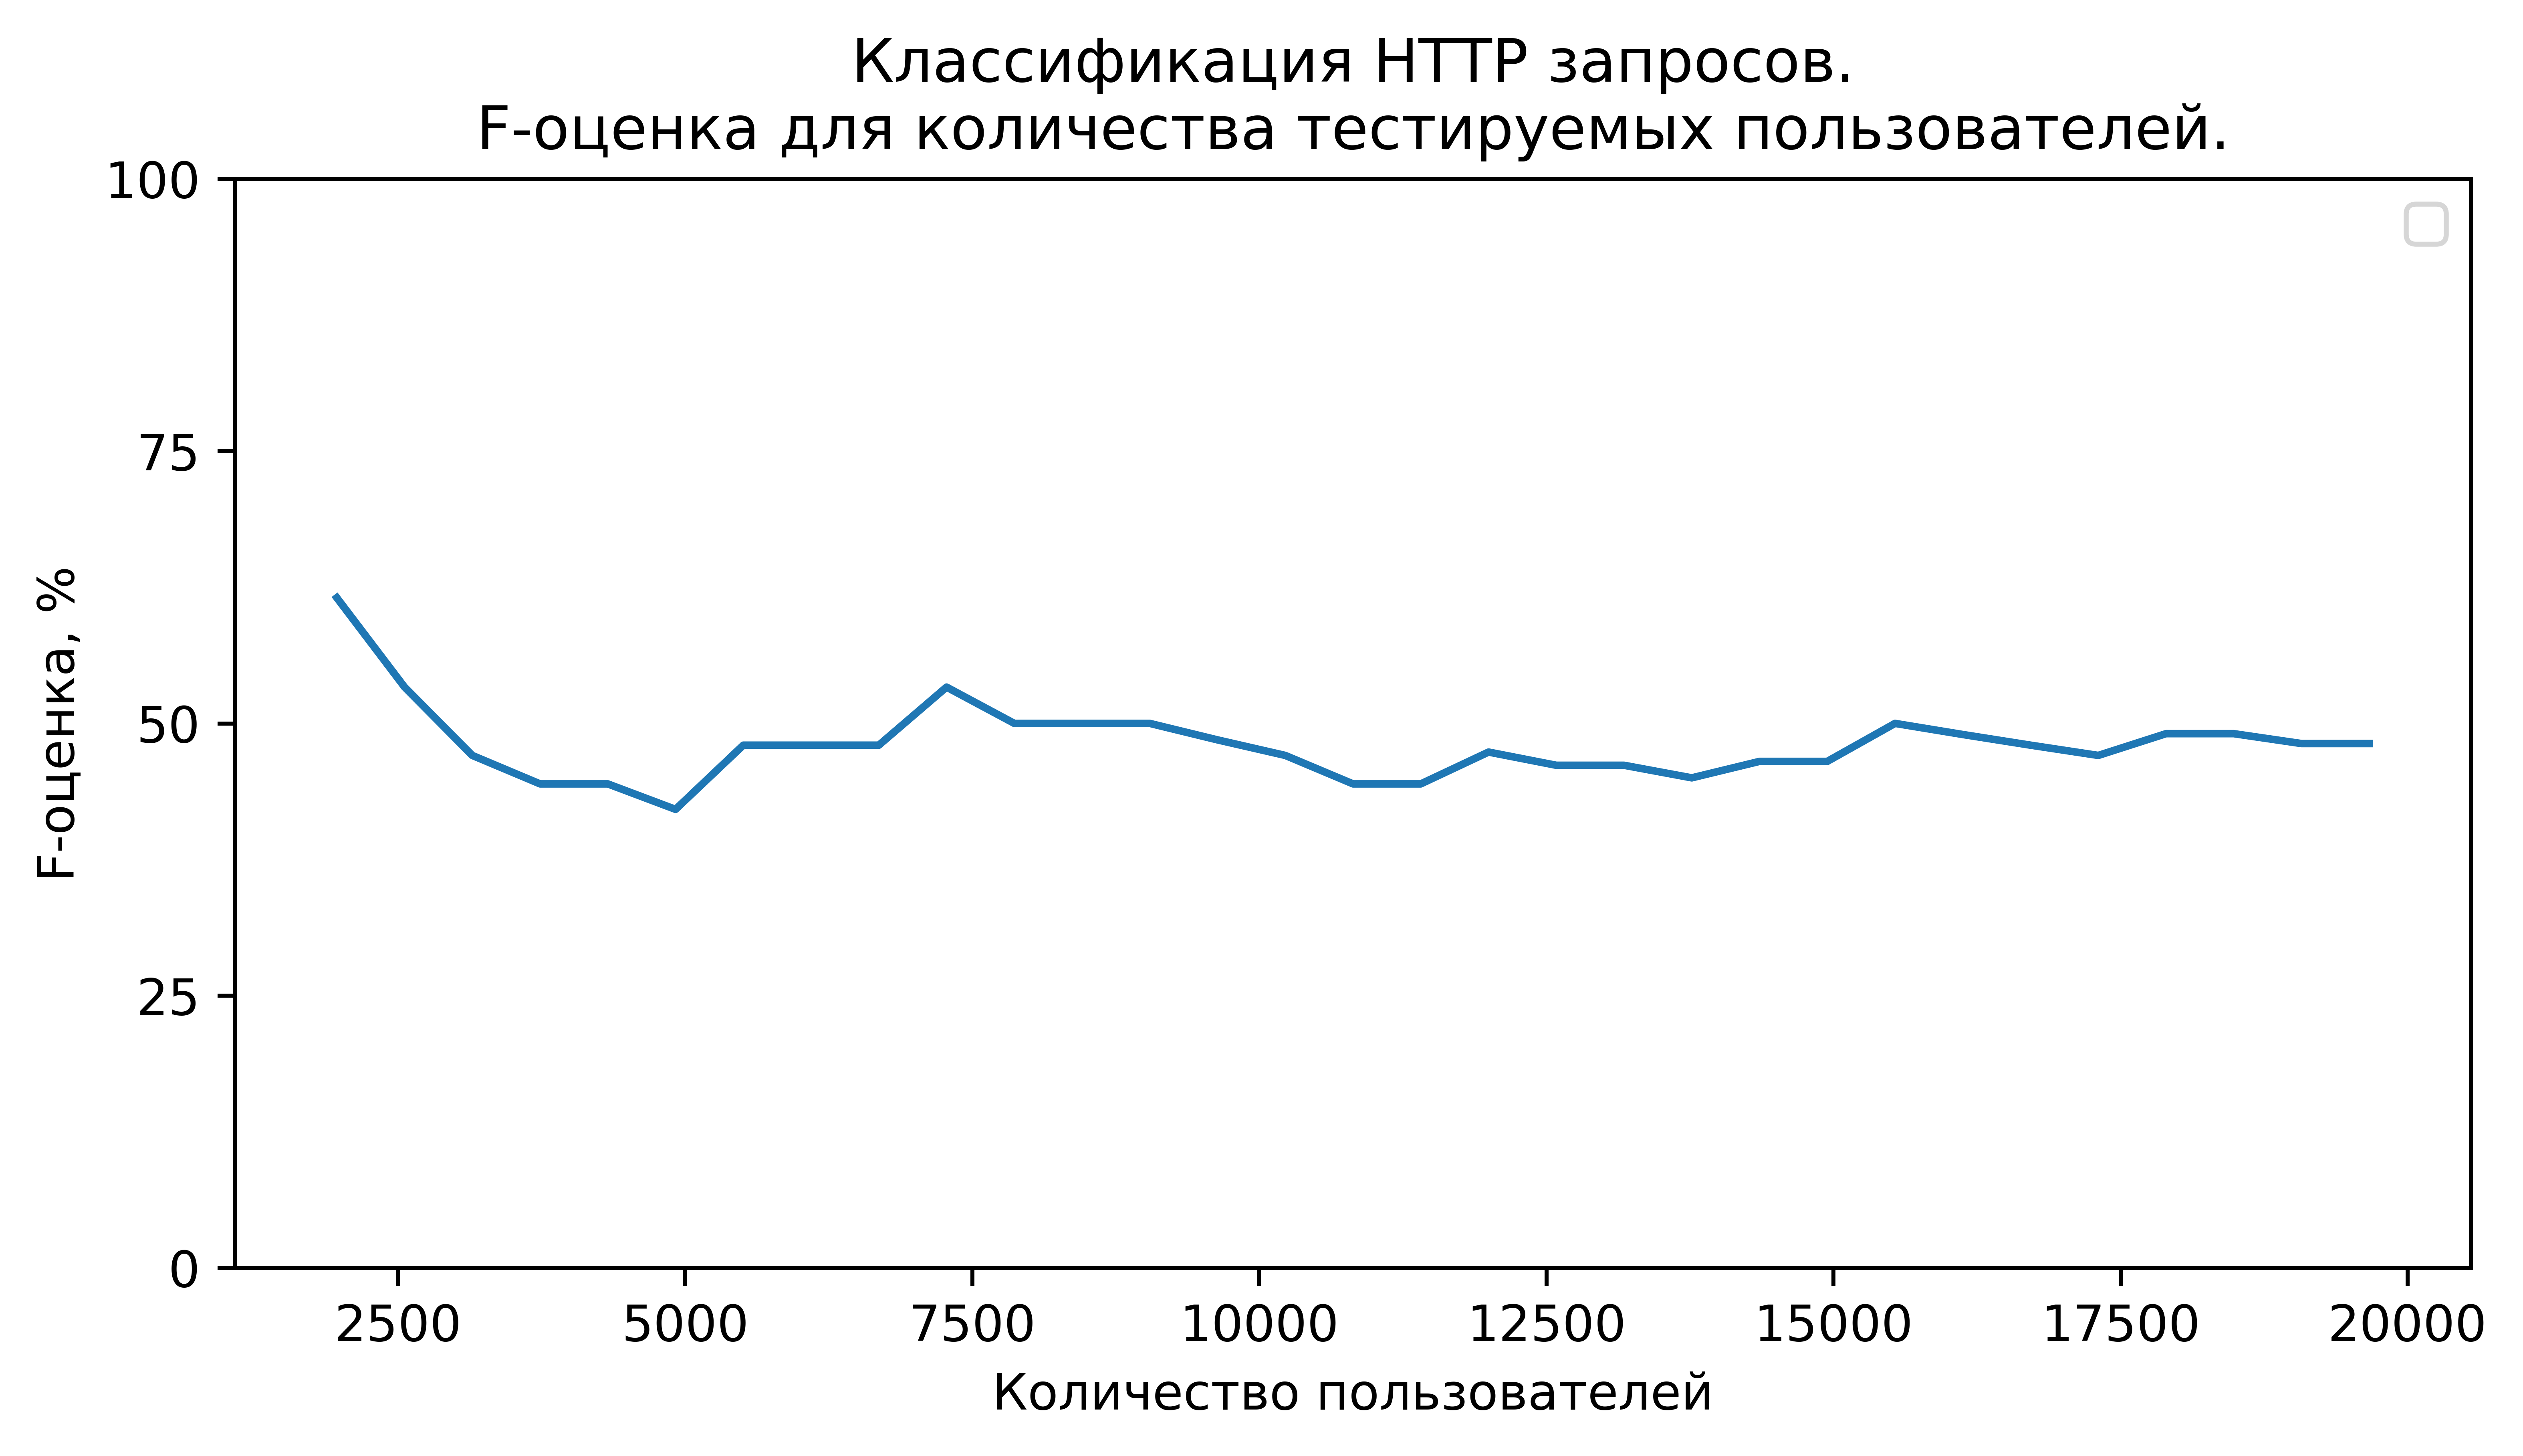

In [31]:
split = np.arange(0.1, 1, 0.03)
holdout_scores = []

for i in split:
    train_test_split_bound = int(grouped.shape[0] * i)
    holdout_scores.append(f1_score(grouped['isBot'][:train_test_split_bound], grouped['predict'][:train_test_split_bound]))
    

plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,100)
plt.yticks(np.linspace(0,100,5,endpoint=True))
plt.ylabel('F-оценка, %')
plt.xlabel('Количество пользователей')
plt.plot(split * grouped.shape[0], np.multiply(holdout_scores, 100))
plt.title('Классификация HTTP запросов.\nF-оценка для количества тестируемых пользователей.')
plt.savefig(GRAPH_PATH + 'batch_http.png', dpi=900)
plt.legend();

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(grouped['isBot'], grouped['predict']) / confusion_matrix(grouped['isBot'], grouped['predict']).sum()

array([[9.97915184e-01, 1.01698363e-03],
       [4.06793451e-04, 6.61039357e-04]])

In [34]:
confusion_matrix(grouped['isBot'], grouped['predict']).ravel()

array([19625,    20,     8,    13])